In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [2]:
# Some tools I made for testing out if certain datasets are suitable
'''# Tool for removing outliers
q = df["total"].quantile(0.99)
df = df[df["total"] < q]

# Tool for grouping by date and plotting the counts over time
# Count the number of occurences with the same date/time
df["Sales"] = df['Date'].apply(lambda x: (df['Date'] == x).sum())

# Plot the counts for the same timeframe
scaler = MinMaxScaler()

counts= []
date_list = df["Date"].unique()

for date in date_list:
    # for each unique date, take the first row and get the count of rows
    row = df[df["Date"] == date].iloc[0]
    counts.append(row["Sales"])

x = date_list
y = counts
y = np.array(y).reshape(-1, 1)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
y_scaled = scaler.fit_transform(y)

ax.plot(x,y_scaled, lw=1)
ax.legend(loc="lower left")
plt.show()'''

'# Tool for removing outliers\nq = df["total"].quantile(0.99)\ndf = df[df["total"] < q]\n\n# Tool for grouping by date and plotting the counts over time\n# Count the number of occurences with the same date/time\ndf["Sales"] = df[\'Date\'].apply(lambda x: (df[\'Date\'] == x).sum())\n\n# Plot the counts for the same timeframe\nscaler = MinMaxScaler()\n\ncounts= []\ndate_list = df["Date"].unique()\n\nfor date in date_list:\n    # for each unique date, take the first row and get the count of rows\n    row = df[df["Date"] == date].iloc[0]\n    counts.append(row["Sales"])\n\nx = date_list\ny = counts\ny = np.array(y).reshape(-1, 1)\n\nfig, ax = plt.subplots(1, 1, figsize=(15, 2))\ny_scaled = scaler.fit_transform(y)\n\nax.plot(x,y_scaled, lw=1)\nax.legend(loc="lower left")\nplt.show()'

In [3]:
# dataset source: 
# https://www.kaggle.com/datasets/jarredpriester/global-monthly-methane-observations
# Reading csv from file
df = pd.read_csv("methane_monthly.csv")
# The data just has two important features, the average monthly methane concentration in the air and the respective month
# the concentration is a global average calculated and provided by NOAA’s Earth System Research Laboratory
# https://gml.noaa.gov/ccgg/trends_ch4/
# A lot of datasets I tried before had very messy data with little clear potential for forecasting (too irregular, no visible trends, etc.)
df


,year,month,decimal,average
0,1983,7,1983.542,1626.58
1,1983,8,1983.625,1627.88
2,1983,9,1983.708,1638.49
3,1983,10,1983.792,1644.80
4,1983,11,1983.875,1642.58
...,...,...,...,...
478,2023,5,2023.375,1920.00
479,2023,6,2023.458,1915.94
480,2023,7,2023.542,1914.56
481,2023,8,2023.625,1919.15


In [4]:
# There are no missing values, which is very good since it's difficult to manage
# (especially longer) gaps for forecasting as it's often one of the major, 
# if not the only feature that the forecast will be based on
print(f"Total number of NaN in Dataframe:\n{df.isnull().sum().sum()}")

df.describe()
# I will do some reformatting to the dataframe
# Sadly just a bit shy of 500 rows, but based on the plots below it looks good enough to me
# combine year and month to time column
# dropping all columns apart from time and average 
df["time"] = df["month"].astype(str) + "/" + df["year"].astype(str)
df = df.drop(['decimal', 'month', 'year'], axis=1)
df["time"] = pd.to_datetime(df["time"])

target_col = "average"

df

Total number of NaN in Dataframe:
0


C:\Users\tomco\AppData\Local\Temp\ipykernel_36376\605562141.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["time"] = pd.to_datetime(df["time"])


,average,time
0,1626.58,1983-07-01
1,1627.88,1983-08-01
2,1638.49,1983-09-01
3,1644.80,1983-10-01
4,1642.58,1983-11-01
...,...,...
478,1920.00,2023-05-01
479,1915.94,2023-06-01
480,1914.56,2023-07-01
481,1919.15,2023-08-01


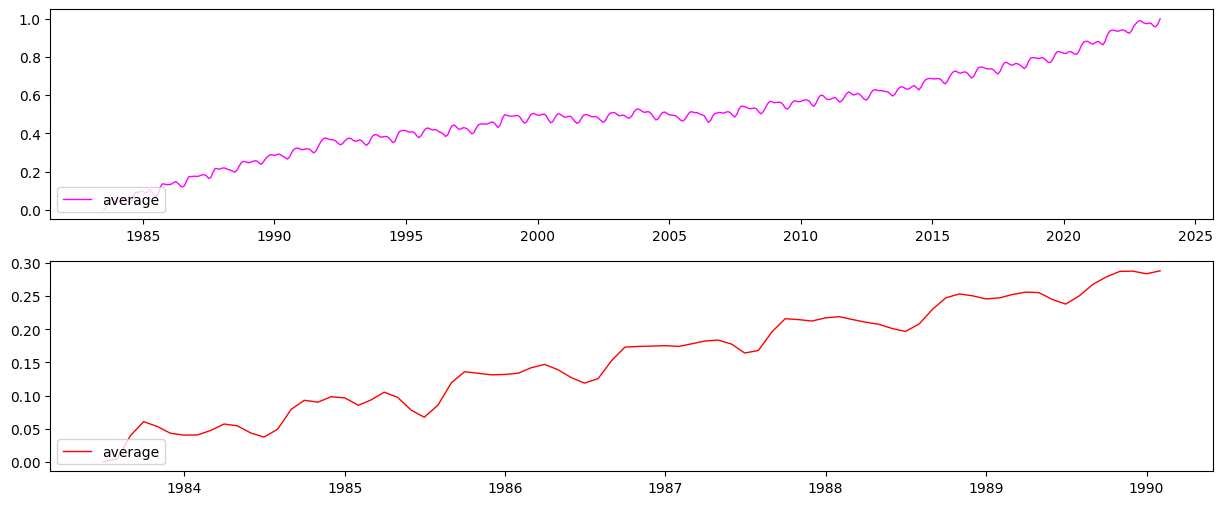

In [5]:
# MinMaxScaler to scale all values between 0 and 1
scaler = MinMaxScaler()

# Only column requiring scaling is the monthly average
df[[target_col]] = scaler.fit_transform(df[[target_col]])

# Creating a numeric index
df.index = df.index + 1

cutoff = len(df)

# List of colours to get the graphs in different colours
colours = ["magenta", "red", "blue", "green", "orange", "cyan", "y", "black", "navy", "brown", "purple"]
fig, axs = plt.subplots(2, 1, figsize=(15,6))
        
# Get values in the current column until the cutoff point
# and scale between 0 and 1 (only for the plotting part for now)
y = df[[target_col]].iloc[:cutoff]

# Set the x-axis values, so one step per row
x = df["time"].iloc[:cutoff]
# Plot the data
axs[0].plot(x,y, lw=1, c=colours[0], label=target_col)
axs[0].legend(loc="lower left")

cutoff = int(cutoff/6)
y = df[[target_col]].iloc[:cutoff]
x = df["time"].iloc[:cutoff]
# Plot the data
axs[1].plot(x,y, lw=1, c=colours[1], label=target_col)
axs[1].legend(loc="lower left")
plt.show()

# The repeating pattern of yearly changes as well as the overall trend look promising
# (for the purpose of creating this forecasting model, obviously not when thinking about what it signifies)
# I made two graphs, one for the whole timeframe and another for a shorter one to see the yearly pattern better

In [6]:
# Doing an 80/20 split
# for train/test
cutoff = int(len(df) * 0.80)

# train data
X_train = df.index[0:cutoff]
y_train = df[target_col].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[target_col].iloc[cutoff:]

# convert to NumPy array-format (expected by the generators)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1
train_series = y_train.reshape((len(y_train), n_features))
test_series = y_test.reshape((len(y_test), n_features))

In [7]:
# TimeseriesGenerators, for train and test
from keras.preprocessing.sequence import TimeseriesGenerator

# This is the number of values each timestep makes up
# so with 1000 points total, look_back being 20 => 50 time steps
look_back  = 16

# using 1 => using time steps
# anything above 1 => windowing (instead of time steps)
window_size = 1

# the amount of data fed into the neural network while training
# the bigger it is, the faster the training
# but with forecasts it also affects the performance
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

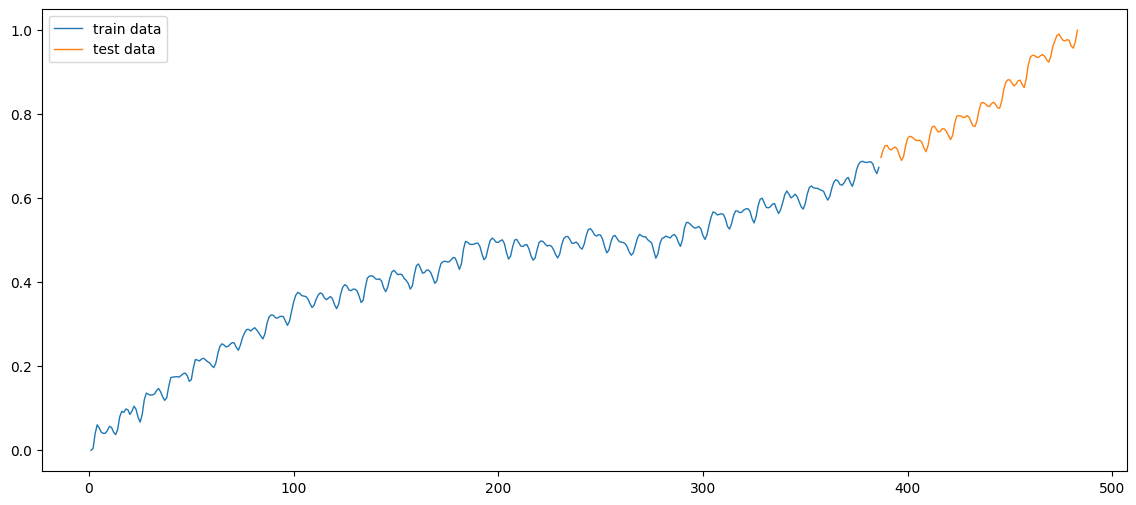

In [8]:
# Visualising the train/test split in the data
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test, y_test,  lw=1, label='test data')
ax.legend(loc="upper left")
plt.show()

In [9]:
import keras_tuner
from keras import layers


# the neural network architecture, some layers are set
# while others are variable and changed according to the keras tuner
def build_model(hp):
    model = keras.Sequential()
    # Input layer is set to 32 nodes
    model.add(layers.SimpleRNN(32, activation="relu", input_shape=(look_back, n_features,), return_sequences=True))

    # Here the tuner tries out different combinations of layer and neuron numbers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.SimpleRNN(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # Dropout layers are also included some of the time (not in each run)
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.2))

    # output layer is always the same (regression)
    model.add(layers.Dense(1))

    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2)

    # compile all and return model for tuning
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse"
    )

    return model

build_model(keras_tuner.HyperParameters())

# we need to define the build_model -function
# that has the approximate structure of the neural network
# and determines which details the keras tuner is going to experiment on

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="optimizations",
    project_name="methane_concentration",
)

# Executing the search, but of course higher complexity and number of epochs
# will make the training slower and more resource-intensive
tuner.search(train_generator, epochs=100, validation_data=(test_generator))

# Getting the best 2 models
models = tuner.get_best_models(num_models=2)

# Summary for the best model
best_model = models[0]
best_model.summary()

Trial 5 Complete [00h 08m 36s]
val_loss: 7.58865741469587e-05

Best val_loss So Far: 1.960567290855882e-05
Total elapsed time: 00h 33m 50s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16, 32)            1088      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1889 (7.38 KB)
Trainable params: 1889 (7.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
from IPython.display import clear_output

# Custom Callback for plotting the training data in real-time
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        
        # Make lists of the finished epochs and training metrics
        self.x = []
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        # after each epoch, append the metrics to the lists
        self.x.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        clear_output(wait=True)
        
        # And plot the loss & val_loss
        plt.plot(self.losses, label="loss")
        plt.plot(self.val_losses, label="val_loss")
        plt.legend()
        plt.show()

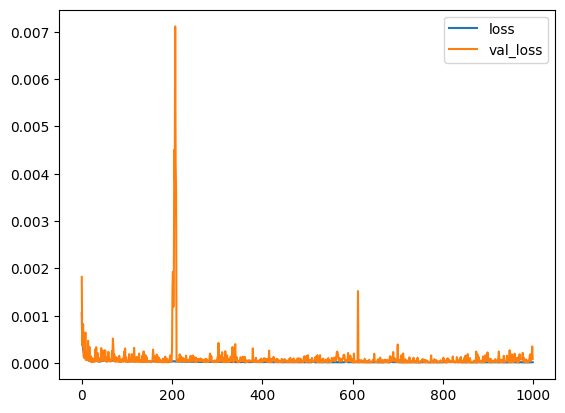

370/370 [==============================] - 2s 4ms/step - loss: 1.6393e-05 - val_loss: 8.7228e-05


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# rule of thumb: RNN is usually good with short-term trends
# while LSTM is usually good with long-term trends
# effectiveness depends on the situation/dataset
from keras.layers import LSTM
from keras.layers import SimpleRNN

# Simple RNN network
# number of neurons can be adjusted
model = Sequential()
model.add(SimpleRNN(32, activation="relu",input_shape=(look_back, n_features), return_sequences=True)),
model.add(SimpleRNN(16, activation="relu")),
model.add(Dense(1)),
model.compile(optimizer='adam', loss='mse')

mc = ModelCheckpoint("rnn_best_model.keras", monitor='val_loss', mode='min', save_best_only=True)

# Reducing the learning rate on plateau
#rd_lr_op = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001)

# Early stop to stop the training early if it stops progressing
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=1)
create_plots = CustomCallback()

# Creating a list of callbacks
callbacks = [mc, create_plots, early_stop]

# start training the model, use also validation data for metrics later
model.fit(train_generator,epochs=1000, callbacks=callbacks, verbose=1, validation_data=test_generator)

In [16]:
# load the best model from the model checkpoint
model = keras.models.load_model("rnn_best_model.keras")

In [17]:
# Create test predictions
test_predictions  = model.predict(test_generator)

81/81 [==============================] - 1s 2ms/step


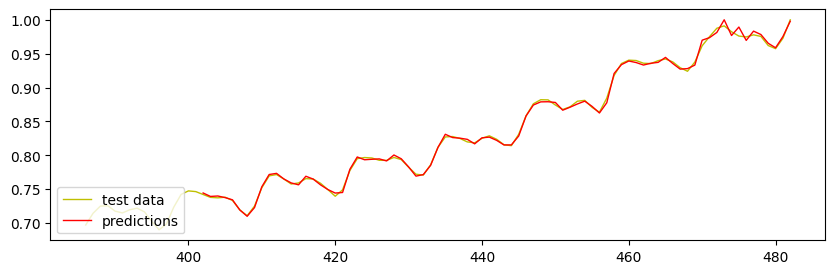

In [18]:
# this code is not optimal
# our code should instead scale based on the X_train / X_test
x1 = np.arange(0,len(y_train))
x2 = np.arange(len(y_train),len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the trianing data to inspect the 
# predictions vs. test data separately
#ax.plot(x1,y_train, lw=1, label='train data')
ax.plot(x2,y_test, lw=1, c='y', label='test data')
ax.plot(x3,test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="lower left")
plt.show()

# Apart from the irregularities at the last part
# it matches really closely, which is promising
# but from experience does not necessarily carry over to the extrapolation part

In [19]:
 # TF evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# These values are very close 
# Which hints at a good model 
# or at least one that is consistent between training and testing results

370/370 [==============================] - 1s 2ms/step - loss: 9.0544e-06
Training loss: 9.05439901544014e-06
81/81 [==============================] - 0s 2ms/step - loss: 1.0760e-05
Testing loss: 1.0759707038232591e-05


In [20]:
# make a separate copy of the test values
# that matches with y_test
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# the typical error metrics
# MAE - Mean average error
# MAPE score => less than 10% => excellent result
# MAPE score => 10-20 % => good result
# MAPE score => 20-50% => okay / reasonable / decent result
# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values
# it's possible to get a weird MAPE result with synthetic test data
# because the data is so predicatble
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test , test_predictions), 2), " units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), " units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test , test_predictions)), 2), " units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test , test_predictions), 2))

# Very promising metrics here

MAPE (mean average precision error):
0.28 %

MAE
0.0  units

MSE
0.0  units^2

RMSE:
0.0  units

R-squared:
1.0


In [21]:
# EXTRAPOLATION TEST 
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next n values
n = 140
for i in range(n):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

1/1 [==============================] - 0s 20ms/step


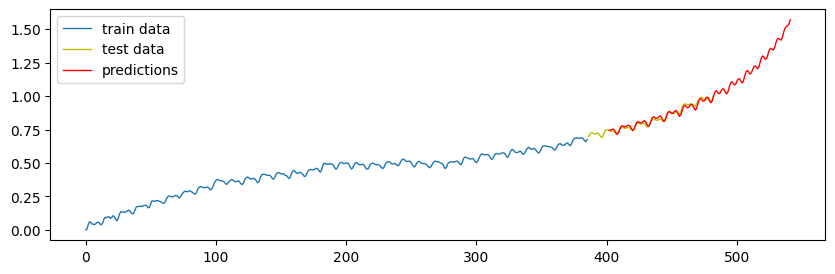

In [22]:
# Plotting the train/test data and overlaying the extrapolated data
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# It's also easy to hide the training data to inspect the
# the predictions vs. test data more closely
ax.plot(x1, y_train, lw=1, label='train data')
ax.plot(x2, y_test, lw=1, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()

In [ ]:
# I like the performance of the RNN-model over the LSTM version for this example
# The performance for both is excellent if it's just about standard predictions
# But when getting to extrapolation all bets are off
# It's possible to just retrain the model until it looks good, but I think 
# it should be taken with a grain of salt how good it is in general
# I am writing more of my thoughts at the end of the LSTM neural network version of this

# Here the extrapolation looks good for the part covering the test data
# but then I feel like it is matching the exponential behaviour too closely
# that it goes a bit overboard
# At least I hope so, that would be an incredibly dire methane concentration increase if it were
# to happen like that in real life
# Also, this does not take into account the effect of humans trying to counteract it
# because that effect has not been sufficiently noticeable in the data
# But it is likely that it will play more and more of a role as time goes on

In [ ]:
# Testing different starting points for the extrapolation

In [83]:
# Function to try out extrapolation with different starting points and look backs

def extrapolate(data, start, look_back, num_preds):
    # EXTRAPOLATION TEST 
    extrapolation = list()
    seed_batch    = data[start-look_back:(start)].reshape((1,look_back, n_features))
    current_batch = seed_batch

    # extrapolate the next n values
    for i in range(num_preds):
        predicted_value = model.predict(current_batch, verbose=0)[0]
        extrapolation.append(predicted_value) 
        current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

    if len(data) == len(y_test):
        start = start + len(y_train)

    end = start + len(extrapolation)

    # Plotting the train/test data and overlaying the extrapolated data
    x1 = np.arange(0, len(y_train))
    x2 = np.arange(len(y_train), len(y_train) + len(y_test))
    x3 = np.arange(start, end)

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    # It's also easy to hide the training data to inspect the
    # the predictions vs. test data more closely
    ax.plot(x1, y_train, lw=1, label='train data')
    ax.plot(x2, y_test, lw=1, c='y', label='test data')
    ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
    ax.legend(loc="upper left")
    plt.show()

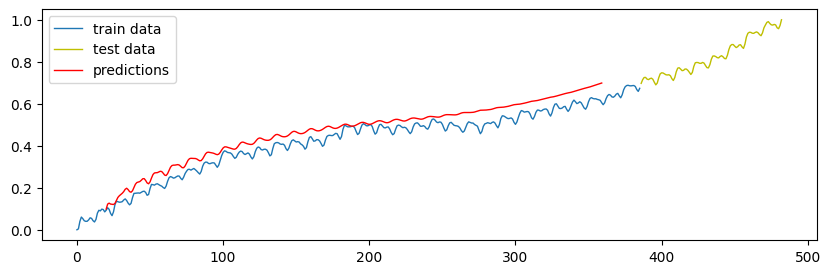

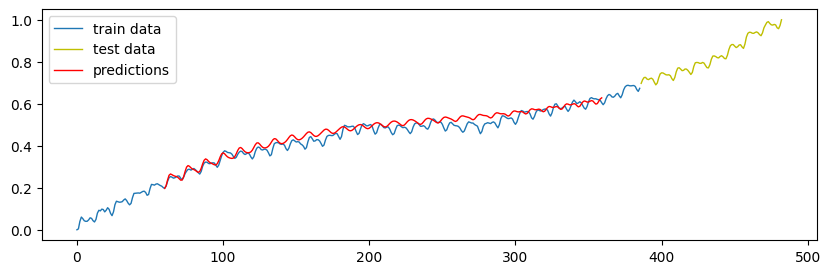

In [91]:
# Start can't be higher than the length of the data being extrapolated from
# e.g. y_train is 386 points long, so 386 is the last point that can be extrapolated from
# the actual data used for the extrapolation is start - look_back
# so the start point can't be lower than the look_back

# Extrapolating from start 20, look_back 16 and extrapolating 340 points into the future
extrapolate(y_train, 20, 16, 340)

# Just 300 points but starting from 60
extrapolate(y_train, 60, 16, 300)

# Other than the diminishing yearly pattern, this is more accurate than I thought
# but it's training data, so I think it just shows that it recognises the situation
# and applies as best as it can what it knows from the training

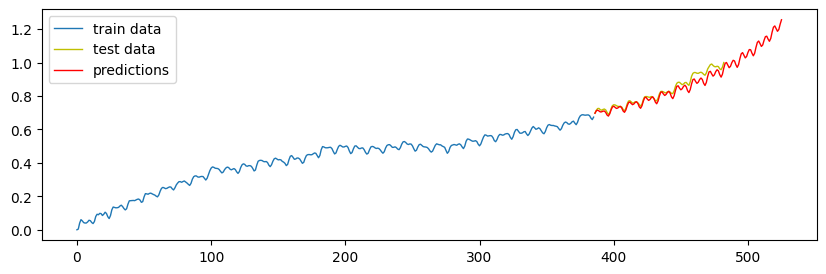

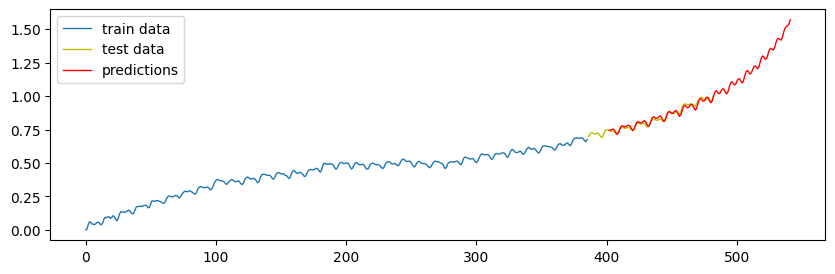

In [87]:
# Some more testing with good results
extrapolate(y_train, 386, 16, 140)
extrapolate(y_test, 16, 16, 140)

# Changing the look back at all basically breaks the model completely
# that's something to take into account

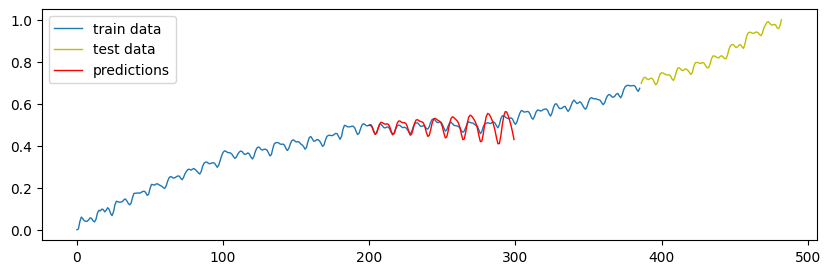

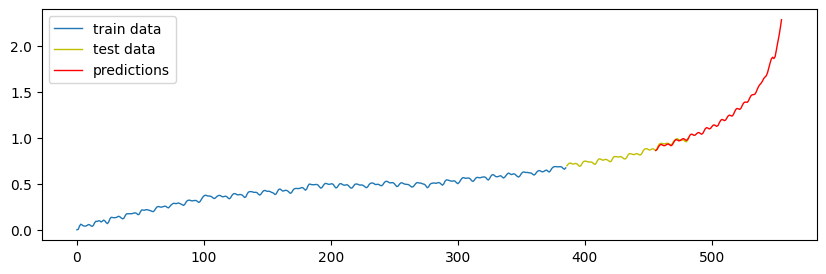

In [89]:
# Some less optimal extrapolations
extrapolate(y_train, 200, 16, 100)
extrapolate(y_test, 70, 16, 100)

In [ ]:
# I have more final thoughts in the end of the LSTM time series forecasting notebook
# But when it comes to applications in real life, I can already say that it is pretty similar
# to the previous time series classification 
# Predictions and extrapolation can be good to make all sorts of forecasts
# weather, anomaly detection, predictive maintenance
# also stock prices, vital signs of medical patients are big hopes for future developments
# electricity and other kind of consumer demand can be great use cases as well
# It's very tricky to get something good and usable with time series forecasting
# But probably the most exciting, since it feels like "you can tell the future"
# if it works better than what experts in the respective field could predict
# I think there is a lot of money to be made with new advancements, and not just looking at the stock market here
# making decisions is hard and takes responsibility
# Having a model make the decisions for you is bad if it doesn't work well
# but if it actually does work, it makes it a lot easier to act decisively
# e.g. a tried and tested model predicting a bad summer with lots of forest fires
# would likely do better to motivate people to prevent the issue
# Although one problem still remains, if people take effective countermeasures
# it will often feel like they weren't needed in the first place
# as Covid-19 has shown
# Still, I think there is a lot of unrealised potential here